# SCAN: Initial modeling with memory models

In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras import layers

import tensorflow_datasets as tfds
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import data_utils
import model_utils

from tqdm import tqdm, trange

import sys; sys.path.append('../')
import transformer_modules
import utils

[TODO]

- implement gating
- 2-stage training

## Date prep

In [2]:
scan_split = 'addprim_jump'
eval_ds_size = 1000

In [3]:
train_ds, test_ds, command_vectorizer, action_vectorizer = data_utils.load_scan_ds(scan_split)

In [4]:
print('# training samples:', len(train_ds))
print('# testing samples:', len(test_ds))
print()

print('sample of input/target/label samples...')
# print sample of dataset
for (s, t), y in train_ds.take(3):
    print(f'INPUT: {data_utils.invert_seq_vector(s.numpy(), command_vectorizer)}')
    print(f'INPUT: {s.numpy()}')
    print(f'TARGET: {data_utils.invert_seq_vector(t.numpy(), action_vectorizer)}')
    print(f'TARGET: {t.numpy()}')
    print(f'LABEL: {data_utils.invert_seq_vector(y.numpy(), action_vectorizer)}')
    print(f'LABEL: {y.numpy()}')
    print()

# training samples: 14670
# testing samples: 7706

sample of input/target/label samples...
INPUT: walk after look right     
INPUT: [ 8 12 10  2  0  0  0  0  0]
TARGET: <START> I_TURN_RIGHT I_LOOK I_WALK <END>                                            
TARGET: [7 2 6 4 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]
LABEL: I_TURN_RIGHT I_LOOK I_WALK <END>                                             
LABEL: [2 6 4 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]

INPUT: walk left thrice after walk left thrice  
INPUT: [ 8  3  5 12  8  3  5  0  0]
TARGET: <START> I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <END>                                   
TARGET: [7 3 4 3 4 3 4 3 4 3 4 3 4 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]
LABEL: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_

In [5]:
mem_train_ds = data_utils.create_memory_ds(train_ds, n_mems=16)
mem_test_ds = data_utils.create_memory_ds(test_ds, n_mems=16, memory_bank=train_ds)

In [6]:
# TODO: perhaps sample via a generator so that different random samples of memory can be used for each epoch/batch?
# this is at the expense of speed. from_tensor_slices is faster since .from_generator runs in python rather than C++

## Utilities

In [7]:
def create_memory_processor(embedding_dim, enc_kwargs, dec_kwargs, hidden_dense_size,
    source_vocab=len(command_vectorizer.get_vocabulary()), target_vocab=len(action_vectorizer.get_vocabulary())):

    # define layers
    x_embedder = layers.Embedding(input_dim=source_vocab, output_dim=embedding_dim)
    y_embedder = layers.Embedding(input_dim=target_vocab, output_dim=embedding_dim)
    add_pos_embedding_src = transformer_modules.AddPositionalEmbedding()
    add_pos_embedding_tgt = transformer_modules.AddPositionalEmbedding()

    # NOTE: currently, self-attention in the decoder of the memory processor is causal! need not be
    encoder = transformer_modules.Encoder(**enc_kwargs)
    decoder = transformer_modules.Decoder(**dec_kwargs)

    hidden_dense = layers.Dense(hidden_dense_size, activation='relu')
    out_dense = layers.Dense(action_vectorizer.vocabulary_size())

    # define model
    inputs = layers.Input(shape=train_ds.element_spec[0][0].shape)
    targets = layers.Input(shape=train_ds.element_spec[0][1].shape)
    x = x_embedder(inputs)
    x = add_pos_embedding_src(x)
    x = encoder(x)
    y = y_embedder(targets)
    y = add_pos_embedding_tgt(y)
    y = decoder(y, x)
    out = y

    model = tf.keras.Model(inputs=[inputs, targets], outputs=out, name='memory_processor')
    return model

## End-to-end Training of Memory Model

In [8]:
# hyperparams
source_vocab = len(command_vectorizer.get_vocabulary())
target_vocab = len(action_vectorizer.get_vocabulary())
embedding_dim = 64

hidden_dense_size = 128
enc_kwargs = dict(num_layers=2, num_heads=4, dff=128, layernorm_first=True)
hier_attn_kwargs = dict(key_dim=64//4, value_dim=None, n_heads=4, symmetric_kernel=False)
dec_kwargs = dict(num_layers=2, num_heads=4, dff=128, layernorm_first=True, hier_attn_kwargs=hier_attn_kwargs)

# memory-processer is a mini-transformer transformer
mem_enc_kwargs = mem_dec_kwargs = dict(num_layers=1, num_heads=4, dff=64, layernorm_first=True)
mem_processor_kwargs = dict(embedding_dim=embedding_dim, mem_enc_kwargs=mem_enc_kwargs,
    mem_dec_kwargs=mem_dec_kwargs, hidden_dense_size=64)

In [9]:
from hierarchical_memory_decoder import HierMemoryDecoder

In [10]:
class HierarchicalAttnMemoryModel(tf.keras.Model):
    def __init__(self, source_vocab, target_vocab, embedding_dim, enc_kwargs, dec_kwargs, mem_processor_kwargs, **kwargs):
        super(HierarchicalAttnMemoryModel, self).__init__(**kwargs)
        self.source_vocab = source_vocab
        self.target_vocab = target_vocab
        self.embedding_dim = embedding_dim
        self.enc_kwargs = enc_kwargs
        self.dec_kwargs = dec_kwargs
        self.mem_processor_kwargs = mem_processor_kwargs

        self.x_embedder = layers.Embedding(input_dim=source_vocab, output_dim=embedding_dim, name='source_embedder')
        self.y_embedder = layers.Embedding(input_dim=target_vocab, output_dim=embedding_dim, name='target_embedder')
        self.add_pos_embedding_src = transformer_modules.AddPositionalEmbedding(name='pos_embedding_src')
        self.add_pos_embedding_tgt = transformer_modules.AddPositionalEmbedding(name='pos_embedding_tgt')

        self.encoder = transformer_modules.Encoder(**enc_kwargs, name='encoder')
        self.decoder = HierMemoryDecoder(**dec_kwargs, name='decoder')

        self.memory_processor = create_memory_processor(embedding_dim, mem_enc_kwargs, mem_dec_kwargs, hidden_dense_size)

        self.hidden_dense = layers.Dense(hidden_dense_size, activation='relu', name='hidden_dense')
        self.out_dense = layers.Dense(action_vectorizer.vocabulary_size(), name='output')

    def set_memory_signature(self, n_memories, mem_length):
        self.n_memories = n_memories
        self.mem_length = mem_length

    def process_memory(self, mem_inputs, mem_targets):
        # TODO: can i make the process of defining the output signature more elegant?
        # n_m = tf.shape(mem_inputs)[1]
        # tgt_len = tf.shape(mem_targets)[2]
        out_dim = self.embedding_dim #self.memory_processor.output_shape[-1]
        out_sig = tf.TensorSpec([self.n_memories, self.mem_length, out_dim], tf.float32)

        processed_mem = tf.map_fn(self.memory_processor, (mem_inputs, mem_targets), fn_output_signature=out_sig)

        # NOTE (temporary note)
        # alternatively, cross-attend from target seq to input seq? (in this case target seq is shorter)
        # but pre-training such a transformer would be difficult
        # processed_mem = tf.map_fn(self.memory_processor, (mem_targets, mem_inputs), fn_output_signature=out_sig)

        return processed_mem

    def call(self, inputs):
        ((input_seq, target_seq), (mem_inputs, mem_targets)) = inputs

        x = self.x_embedder(input_seq)
        x = self.add_pos_embedding_src(x)
        x = self.encoder(x)

        # process memory sequence
        processed_memory = self.process_memory(mem_inputs, mem_targets)

        # process target sequence (causally)
        y = self.y_embedder(target_seq)
        y = self.add_pos_embedding_tgt(y)
        y = self.decoder(y, x, processed_memory)
        out = self.hidden_dense(y)
        out = self.out_dense(out)

        return out

In [11]:
model = HierarchicalAttnMemoryModel(source_vocab, target_vocab, embedding_dim, enc_kwargs, dec_kwargs, mem_processor_kwargs)

In [12]:
# TODO: is it possible to fix building so that shapes work?
for x, y in mem_train_ds.batch(32).take(1):
    ((input_seq, target_seq), (mem_inputs, mem_targets)) = x
    print('input_seq:', input_seq.shape[1:])
    print('target_seq:', target_seq.shape[1:])
    print('mem_inputs:', mem_inputs.shape[1:])
    print('mem_targets:', mem_targets.shape[1:])
    # get shapes for building model shape

    input_shape = [None, *input_seq.get_shape().as_list()[1:]]
    target_shape = [None, *target_seq.get_shape().as_list()[1:]]
    mem_input_shape = [None, *mem_inputs.get_shape().as_list()[1:]]
    mem_target_shape = [None, *mem_targets.get_shape().as_list()[1:]]
    inputs_shape = [input_shape, target_shape, mem_input_shape, mem_target_shape]
    print(f'inputs_shape: {inputs_shape}')
    # model((input_seq, target_seq, mem_inputs, mem_targets))
    model.set_memory_signature(n_memories=mem_targets.shape[1], mem_length=mem_targets.shape[2])
    model(x)
    # model.build(inputs_shape)

model.summary()

input_seq: (9,)
target_seq: (49,)
mem_inputs: (16, 9)
mem_targets: (16, 49)
inputs_shape: [[None, 9], [None, 49], [None, 16, 9], [None, 16, 49]]
Model: "hierarchical_attn_memory_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 source_embedder (Embedding  multiple                  960       
 )                                                               
                                                                 
 target_embedder (Embedding  multiple                  640       
 )                                                               
                                                                 
 pos_embedding_src (AddPosi  multiple                  0         
 tionalEmbedding)                                                
                                                                 
 pos_embedding_tgt (AddPosi  multiple                  0         
 tionalEmbedding)      

In [13]:
# compile model and optimization hyperparams
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
metrics = [transformer_modules.TeacherForcingAccuracy(ignore_class=action_vectorizer.get_vocabulary().index(''))]
model.compile(loss=loss, optimizer=optimizer, metrics=metrics, run_eagerly=False)
batch_size = 128

In [14]:
val_size = 1000
val_ds = mem_train_ds.take(val_size).batch(batch_size)
train_ds_ = mem_train_ds.skip(val_size).batch(batch_size)

In [15]:
n_epochs = 10
history = model.fit(train_ds_, validation_data=val_ds, epochs=n_epochs, batch_size=128, verbose=2)

Epoch 1/10
107/107 - 69s - loss: 0.4672 - teacher_forcing_accuracy: 0.4820 - val_loss: 0.1884 - val_teacher_forcing_accuracy: 0.7269 - 69s/epoch - 645ms/step
Epoch 2/10
107/107 - 36s - loss: 0.1857 - teacher_forcing_accuracy: 0.7324 - val_loss: 0.1483 - val_teacher_forcing_accuracy: 0.7712 - 36s/epoch - 333ms/step
Epoch 3/10
107/107 - 36s - loss: 0.1531 - teacher_forcing_accuracy: 0.7681 - val_loss: 0.1204 - val_teacher_forcing_accuracy: 0.8026 - 36s/epoch - 333ms/step
Epoch 4/10
107/107 - 36s - loss: 0.1246 - teacher_forcing_accuracy: 0.8042 - val_loss: 0.0869 - val_teacher_forcing_accuracy: 0.8522 - 36s/epoch - 333ms/step
Epoch 5/10
107/107 - 36s - loss: 0.0942 - teacher_forcing_accuracy: 0.8538 - val_loss: 0.0461 - val_teacher_forcing_accuracy: 0.9359 - 36s/epoch - 333ms/step
Epoch 6/10
107/107 - 36s - loss: 0.0605 - teacher_forcing_accuracy: 0.9107 - val_loss: 0.0321 - val_teacher_forcing_accuracy: 0.9542 - 36s/epoch - 334ms/step
Epoch 7/10
107/107 - 36s - loss: 0.0460 - teacher_fo

In [16]:
from datetime import datetime
datetime_str = datetime.now().strftime("%Y-%m-%d-%H%M%S")
model.save_weights(f'model_checkpoints/memory_model-{scan_split}-{datetime_str}/ckpt') # save model

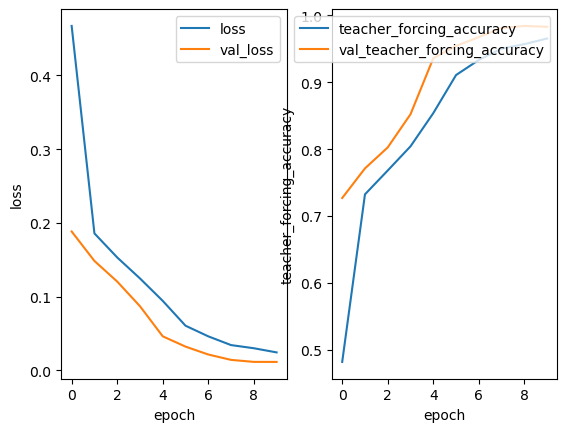

In [17]:
utils.plot_history(history, plot_attrs=('loss', 'teacher_forcing_accuracy'), val=True);

In [18]:
def evaluate_model(model, mem_ds):
    source, target, mem_source, mem_target, label = data_utils.unravel_mem_ds(mem_ds)
    target_length = np.shape(target)[1]

    pred = model_utils.mem_autoregressive_predict_batch(model, source, mem_source, mem_target, target_length,
        start_token=action_vectorizer.get_vocabulary().index('<START>'), batch_size=batch_size)

    full_seq_acc = np.all(pred == label, axis=1).mean()
    print(f'full seq acc: {full_seq_acc}')

    per_token_acc = np.mean(pred == label)
    print(f'per-token acc: {per_token_acc}')

    # teacher-forcing accuracy on test data
    _, tfacc = model.evaluate(mem_ds.batch(batch_size), verbose=False)
    print(f'teacher-forcing accuracy: {tfacc}')

    metrics = dict(pred=pred, label=label, full_seq_acc=full_seq_acc, tfacc=tfacc)

    return metrics

In [19]:
print('TRAIN EVALUATION')
train_metrics = evaluate_model(model, mem_train_ds.take(eval_ds_size))
print('TEST EVALUATION')
test_metrics = evaluate_model(model, mem_test_ds.take(eval_ds_size))

TRAIN EVALUATION


full seq acc: 0.784
per-token acc: 0.9779183673469388
teacher-forcing accuracy: 0.9828125238418579
TEST EVALUATION


full seq acc: 0.0
per-token acc: 0.8507755102040816
teacher-forcing accuracy: 0.6659206748008728


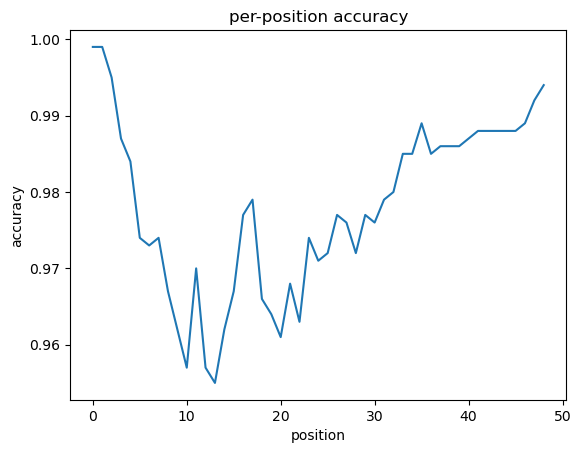

In [20]:
positional_avg_acc = np.mean(train_metrics['pred'] == train_metrics['label'], axis=0)
fig, ax = plt.subplots()
ax.plot(positional_avg_acc);
ax.set_title('per-position accuracy');
ax.set_xlabel('position');
ax.set_ylabel('accuracy');

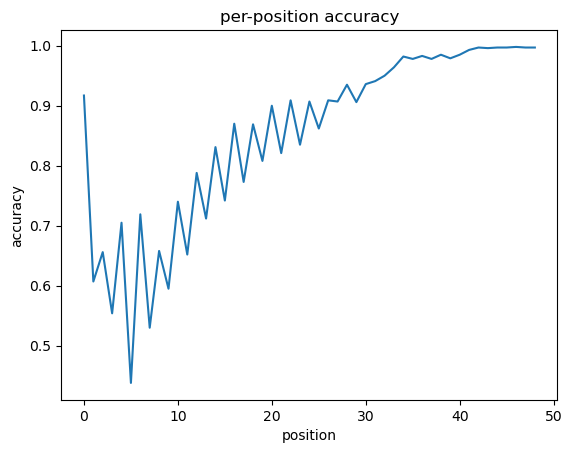

In [21]:
positional_avg_acc = np.mean(test_metrics['pred'] == test_metrics['label'], axis=0)
fig, ax = plt.subplots()
ax.plot(positional_avg_acc);
ax.set_title('per-position accuracy');
ax.set_xlabel('position');
ax.set_ylabel('accuracy');

## 2-Stage Training of Memory Model